In [67]:
import sys
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master')

sys.argv=['']
del sys

In [69]:
!pip install transformers

In [25]:
f=open('/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/data/data/LAB1/test-buduan.txt','r',encoding='utf-8')
dd=f.readlines()

In [70]:
# -*- coding: utf-8 -*-


import time
import sys
import argparse
import random
import copy
import torch
import gc
import pickle
import json
import os
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from utils.metric import get_ner_fmeasure
from model.gazlstm import GazLSTM as SeqModel
from utils.data import Data




def data_initialization(data, gaz_file, train_file, dev_file, test_file):
    data.build_alphabet(train_file)
    data.build_alphabet(dev_file)
    data.build_alphabet(test_file)
    data.build_gaz_file(gaz_file)
    data.build_gaz_alphabet(train_file,count=True)
    data.build_gaz_alphabet(dev_file,count=True)
    data.build_gaz_alphabet(test_file,count=True)
    data.fix_alphabet()
    return data


def predict_check(pred_variable, gold_variable, mask_variable):
    """
        input:
            pred_variable (batch_size, sent_len): pred tag result, in numpy format
            gold_variable (batch_size, sent_len): gold result variable
            mask_variable (batch_size, sent_len): mask variable
    """

    pred = pred_variable.cpu().data.numpy()
    gold = gold_variable.cpu().data.numpy()
    mask = mask_variable.cpu().data.numpy()
    overlaped = (pred == gold)
    right_token = np.sum(overlaped * mask)
    total_token = mask.sum()

    return right_token, total_token


def recover_label(pred_variable, gold_variable, mask_variable, label_alphabet):
    """
        input:
            pred_variable (batch_size, sent_len): pred tag result
            gold_variable (batch_size, sent_len): gold result variable
            mask_variable (batch_size, sent_len): mask variable
    """
    batch_size = gold_variable.size(0)
    seq_len = gold_variable.size(1)
    mask = mask_variable.cpu().data.numpy()
    pred_tag = pred_variable.cpu().data.numpy()
    gold_tag = gold_variable.cpu().data.numpy()
    batch_size = mask.shape[0]
    pred_label = []
    gold_label = []
    for idx in range(batch_size):
        pred = [label_alphabet.get_instance(int(pred_tag[idx][idy])) for idy in range(seq_len) if mask[idx][idy] != 0]
        gold = [label_alphabet.get_instance(gold_tag[idx][idy]) for idy in range(seq_len) if mask[idx][idy] != 0]

        assert(len(pred)==len(gold))
        pred_label.append(pred)
        gold_label.append(gold)

    return pred_label, gold_label


def print_batchword(data, batch_word, n):
    with open("labels/batchwords.txt", "a") as fp:
        for i in range(len(batch_word)):
            words = []
            for id in batch_word[i]:
                words.append(data.word_alphabet.get_instance(id))
            fp.write(str(words))

def save_data_setting(data, save_file):
    new_data = copy.deepcopy(data)
    ## remove input instances
    new_data.train_texts = []
    new_data.dev_texts = []
    new_data.test_texts = []
    new_data.raw_texts = []

    new_data.train_Ids = []
    new_data.dev_Ids = []
    new_data.test_Ids = []
    new_data.raw_Ids = []
    ## save data settings
    with open(save_file, 'wb') as fp:
        pickle.dump(new_data, fp)
    print( "Data setting saved to file: ", save_file)


def load_data_setting(save_file):
    with open(save_file, 'rb') as fp:
        data = pickle.load(fp)
    print( "Data setting loaded from file: ", save_file)
    data.show_data_summary()
    return data

def lr_decay(optimizer, epoch, decay_rate, init_lr):
    lr = init_lr * ((1-decay_rate)**epoch)
    print( " Learning rate is setted as:", lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def set_seed(seed_num):
    random.seed(seed_num)
    torch.manual_seed(seed_num)
    np.random.seed(seed_num)


def evaluate(data, model, name):
    if name == "train":
        instances = data.train_Ids
    elif name == "dev":
        instances = data.dev_Ids
    elif name == 'test':
        instances = data.test_Ids
    elif name == 'raw':
        instances = data.raw_Ids
    else:
        print( "Error: wrong evaluate name,", name)
    #print("instances:",instances)##
    right_token = 0
    whole_token = 0
    pred_results = []
    gold_results = []
    ## set model in eval model
    model.eval()
    batch_size = 1
    start_time = time.time()
    train_num = len(instances)
    total_batch = train_num//batch_size+1
    gazes = []
    ##print("train_num:",train_num)##
    ##print("total_batch:",total_batch)##

    for batch_id in range(total_batch):
        with torch.no_grad():
            ##print("hello")##
            start = batch_id*batch_size
            end = (batch_id+1)*batch_size
            if end >train_num:
                end =  train_num
            instance = instances[start:end]
            if not instance:
                continue
            ##print("hello1")##
            gaz_list,batch_word, batch_biword, batch_wordlen, batch_label, layer_gaz, gaz_count, gaz_chars, gaz_mask, gazchar_mask, mask, batch_bert, bert_mask  = batchify_with_label(instance, data.HP_gpu, data.HP_num_layer, True)
            ##print("hello2")##
            tag_seq, gaz_match = model(gaz_list,batch_word, batch_biword, batch_wordlen, layer_gaz, gaz_count,gaz_chars, gaz_mask, gazchar_mask, mask, batch_bert, bert_mask)
            ##print("hello3")##
            gaz_list = [data.gaz_alphabet.get_instance(id) for batchlist in gaz_match if len(batchlist)>0 for id in batchlist ]
            gazes.append(gaz_list)
            ##print("hello4")##
            ##print("tag_seq:",tag_seq)##
            ##print("batch_label:",batch_label)##
            ##print("mask:",mask)##
            ##print("data.label_alphabet:",data.label_alphabet)##

            if name == "dev":
                pred_label, gold_label = recover_label(tag_seq, batch_label, mask, data.label_alphabet)
            else:
                pred_label, gold_label = recover_label(tag_seq, batch_label, mask, data.label_alphabet)
            ##print("pred_label:",pred_label)##
            ##print("gold_label:",gold_label)##

            pred_results += pred_label
            gold_results += gold_label
    decode_time = time.time() - start_time
    if decode_time == 0:###
        speed = 1###
    else:###
        speed = len(instances)/decode_time
    # print(gold_results)
    acc, p, r, f, right_num = get_ner_fmeasure(gold_results, pred_results, data.tagScheme)
    return speed, acc, p, r, f, pred_results, gazes, right_num


def get_text_input(self, caption):
    caption_tokens = self.tokenizer.tokenize(caption)
    caption_tokens = ['[CLS]'] + caption_tokens + ['[SEP]']
    caption_ids = self.tokenizer.convert_tokens_to_ids(caption_tokens)
    if len(caption_ids) >= self.max_seq_len:
        caption_ids = caption_ids[:self.max_seq_len]
    else:
        caption_ids = caption_ids + [0] * (self.max_seq_len - len(caption_ids))
    caption = torch.tensor(caption_ids)
    return caption


def batchify_with_label(input_batch_list, gpu, num_layer, volatile_flag=False):

    batch_size = len(input_batch_list)
    words = [sent[0] for sent in input_batch_list]
    biwords = [sent[1] for sent in input_batch_list]
    gazs = [sent[3] for sent in input_batch_list]
    labels = [sent[4] for sent in input_batch_list]
    layer_gazs = [sent[5] for sent in input_batch_list]
    gaz_count = [sent[6] for sent in input_batch_list]
    gaz_chars = [sent[7] for sent in input_batch_list]
    gaz_mask = [sent[8] for sent in input_batch_list]
    gazchar_mask = [sent[9] for sent in input_batch_list]
    ### bert tokens
    bert_ids = [sent[10] for sent in input_batch_list]

    word_seq_lengths = torch.LongTensor(list(map(len, words)))
    max_seq_len = word_seq_lengths.max()
    word_seq_tensor = autograd.Variable(torch.zeros((batch_size, max_seq_len))).long()
    biword_seq_tensor = autograd.Variable(torch.zeros((batch_size, max_seq_len))).long()
    label_seq_tensor = autograd.Variable(torch.zeros((batch_size, max_seq_len))).long()
    mask = autograd.Variable(torch.zeros((batch_size, max_seq_len))).byte()
    ### bert seq tensor
    bert_seq_tensor = autograd.Variable(torch.zeros((batch_size, max_seq_len+2))).long()
    bert_mask = autograd.Variable(torch.zeros((batch_size, max_seq_len+2))).long()

    gaz_num = [len(layer_gazs[i][0][0]) for i in range(batch_size)]
    max_gaz_num = max(gaz_num)
    layer_gaz_tensor = torch.zeros(batch_size, max_seq_len, 4, max_gaz_num).long()
    gaz_count_tensor = torch.zeros(batch_size, max_seq_len, 4, max_gaz_num).float()
    gaz_len = [len(gaz_chars[i][0][0][0]) for i in range(batch_size)]
    max_gaz_len = max(gaz_len)
    gaz_chars_tensor = torch.zeros(batch_size, max_seq_len, 4, max_gaz_num, max_gaz_len).long()
    gaz_mask_tensor = torch.ones(batch_size, max_seq_len, 4, max_gaz_num).byte()
    gazchar_mask_tensor = torch.ones(batch_size, max_seq_len, 4, max_gaz_num, max_gaz_len).byte()

    for b, (seq, bert_id, biseq, label, seqlen, layergaz, gazmask, gazcount, gazchar, gazchar_mask, gaznum, gazlen) in enumerate(zip(words, bert_ids, biwords, labels, word_seq_lengths, layer_gazs, gaz_mask, gaz_count, gaz_chars, gazchar_mask, gaz_num, gaz_len)):

        word_seq_tensor[b, :seqlen] = torch.LongTensor(seq)
        biword_seq_tensor[b, :seqlen] = torch.LongTensor(biseq)
        label_seq_tensor[b, :seqlen] = torch.LongTensor(label)
        layer_gaz_tensor[b, :seqlen, :, :gaznum] = torch.LongTensor(layergaz)
        mask[b, :seqlen] = torch.Tensor([1]*int(seqlen))
        bert_mask[b, :seqlen+2] = torch.LongTensor([1]*int(seqlen+2))
        gaz_mask_tensor[b, :seqlen, :, :gaznum] = torch.ByteTensor(gazmask)
        gaz_count_tensor[b, :seqlen, :, :gaznum] = torch.FloatTensor(gazcount)
        gaz_count_tensor[b, seqlen:] = 1
        gaz_chars_tensor[b, :seqlen, :, :gaznum, :gazlen] = torch.LongTensor(gazchar)
        gazchar_mask_tensor[b, :seqlen, :, :gaznum, :gazlen] = torch.ByteTensor(gazchar_mask)

        ##bert
        bert_seq_tensor[b, :seqlen+2] = torch.LongTensor(bert_id)


    if gpu:
        word_seq_tensor = word_seq_tensor.cuda()
        biword_seq_tensor = biword_seq_tensor.cuda()
        word_seq_lengths = word_seq_lengths.cuda()
        label_seq_tensor = label_seq_tensor.cuda()
        layer_gaz_tensor = layer_gaz_tensor.cuda()
        gaz_chars_tensor = gaz_chars_tensor.cuda()
        gaz_mask_tensor = gaz_mask_tensor.cuda()
        gazchar_mask_tensor = gazchar_mask_tensor.cuda()
        gaz_count_tensor = gaz_count_tensor.cuda()
        mask = mask.cuda()
        bert_seq_tensor = bert_seq_tensor.cuda()
        bert_mask = bert_mask.cuda()

    # print(bert_seq_tensor.type())
    return gazs, word_seq_tensor, biword_seq_tensor, word_seq_lengths, label_seq_tensor, layer_gaz_tensor, gaz_count_tensor,gaz_chars_tensor, gaz_mask_tensor, gazchar_mask_tensor, mask, bert_seq_tensor, bert_mask



def train(data, save_model_dir, seg=True):
    train_log = []
    dev_log = []
    test_log = []

    print("Training with {} model.".format(data.model_type))

    #data.show_data_summary()


    model = SeqModel(data)
    print( "finish building model.")

    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.Adamax(parameters, lr=data.HP_lr)

    best_dev = -1
    best_dev_p = -1
    best_dev_r = -1

    best_test = -1
    best_test_p = -1
    best_test_r = -1


    ## start training
    for idx in range(data.HP_iteration):
        epoch_start = time.time()
        temp_start = epoch_start
        print(("Epoch: %s/%s" %(idx,data.HP_iteration)))
        optimizer = lr_decay(optimizer, idx, data.HP_lr_decay, data.HP_lr)
        instance_count = 0
        sample_loss = 0
        batch_loss = 0
        total_loss = 0
        right_token = 0
        whole_token = 0
        random.shuffle(data.train_Ids)
        ## set model in train model
        model.train()
        model.zero_grad()
        batch_size = data.HP_batch_size
        batch_id = 0
        train_num = len(data.train_Ids)
        total_batch = train_num//batch_size+1

        for batch_id in range(total_batch):
            start = batch_id*batch_size
            end = (batch_id+1)*batch_size
            if end >train_num:
                end = train_num
            instance = data.train_Ids[start:end]
            words = data.train_texts[start:end]
            if not instance:
                continue

            gaz_list,  batch_word, batch_biword, batch_wordlen, batch_label, layer_gaz, gaz_count, gaz_chars, gaz_mask, gazchar_mask, mask, batch_bert, bert_mask = batchify_with_label(instance, data.HP_gpu,data.HP_num_layer)

            instance_count += 1
            loss, tag_seq = model.neg_log_likelihood_loss(gaz_list, batch_word, batch_biword, batch_wordlen, layer_gaz, gaz_count,gaz_chars, gaz_mask, gazchar_mask, mask, batch_label, batch_bert, bert_mask)

            right, whole = predict_check(tag_seq, batch_label, mask)
            right_token += right
            whole_token += whole
            sample_loss += loss.data
            total_loss += loss.data
            batch_loss += loss

            if end%20 == 0:
                temp_time = time.time()
                temp_cost = temp_time - temp_start
                temp_start = temp_time
                print(("Instance: %s; Time: %.2fs; loss: %.4f; acc: %s/%s=%.4f"%(end, temp_cost, sample_loss, right_token, whole_token,(right_token+0.)/whole_token)))
                sys.stdout.flush()
                sample_loss = 0
            if end%data.HP_batch_size == 0:
                batch_loss.backward()
                optimizer.step()
                model.zero_grad()
                batch_loss = 0
        train_log.append(total_loss.item())

        temp_time = time.time()
        temp_cost = temp_time - temp_start
        print(("     Instance: %s; Time: %.2fs; loss: %.4f; acc: %s/%s=%.4f"%(end, temp_cost, sample_loss, right_token, whole_token,(right_token+0.)/whole_token))       )
        epoch_finish = time.time()
        epoch_cost = epoch_finish - epoch_start
        print(("Epoch: %s training finished. Time: %.2fs, speed: %.2fst/s,  total loss: %s"%(idx, epoch_cost, train_num/epoch_cost, total_loss)))

        speed, acc, p, r, f, pred_labels, gazs,right_num = evaluate(data, model, "dev")
        
        dev_instance = data.dev_Ids
        dev_gaz_list, dev_batch_word, dev_batch_biword, dev_batch_wordlen, dev_batch_label, dev_layer_gaz, dev_gaz_count, dev_gaz_chars, dev_gaz_mask, dev_gazchar_mask, dev_mask, dev_batch_bert, dev_bert_mask = batchify_with_label(dev_instance, data.HP_gpu,data.HP_num_layer)
        dev_loss, dev_tag_seq = model.neg_log_likelihood_loss(dev_gaz_list, dev_batch_word, dev_batch_biword, dev_batch_wordlen, dev_layer_gaz, dev_gaz_count,dev_gaz_chars, dev_gaz_mask, dev_gazchar_mask, dev_mask, dev_batch_label, dev_batch_bert, dev_bert_mask)
        print('这是dev_loss：',dev_loss)



        
        dev_log.append(dev_loss.item())
        dev_finish = time.time()
        dev_cost = dev_finish - epoch_finish

        if seg:
            current_score = f
            print(("Dev: time: %.2fs, speed: %.2fst/s; acc: %.4f, p: %.4f, r: %.4f, f: %.4f"%(dev_cost, speed, acc, p, r, f)))
        else:
            current_score = acc
            print(("Dev: time: %.2fs speed: %.2fst/s; acc: %.4f"%(dev_cost, speed, acc)))

        if current_score > best_dev:
            if seg:
                print( "Exceed previous best f score:", best_dev)

            else:
                print( "Exceed previous best acc score:", best_dev)

            model_name = save_model_dir
            torch.save(model.state_dict(), model_name)
            #best_dev = current_score
            best_dev_p = p
            best_dev_r = r

        # ## decode test
        speed, acc, p, r, f, pred_labels, gazs,right_num = evaluate(data, model, "test")
        test_log.append(pred_labels)
        test_finish = time.time()
        test_cost = test_finish - dev_finish
        if seg:
            current_test_score = f
            print(("Test: time: %.2fs, speed: %.2fst/s; acc: %.4f, p: %.4f, r: %.4f, f: %.4f"%(test_cost, speed, acc, p, r, f)))
        else:
            current_test_score = acc
            print(("Test: time: %.2fs, speed: %.2fst/s; acc: %.4f"%(test_cost, speed, acc)))

        if current_score > best_dev:
            best_dev = current_score
            best_test = current_test_score
            best_test_p = p
            best_test_r = r

        print("Best dev score: p:{}, r:{}, f:{}".format(best_dev_p,best_dev_r,best_dev))
        print("Test score: p:{}, r:{}, f:{}".format(best_test_p,best_test_r,best_test))
        gc.collect()

    with open(data.result_file,"a") as f:
        f.write(save_model_dir+'\n')
        f.write("Best dev score: p:{}, r:{}, f:{}\n".format(best_dev_p,best_dev_r,best_dev))
        f.write("Test score: p:{}, r:{}, f:{}\n\n".format(best_test_p,best_test_r,best_test))
        f.close()

    return model,train_log,dev_log,test_log

def load_model_decode(model_dir, data, name, gpu, seg=True):
    data.HP_gpu = gpu
    print( "Load Model from file: ", model_dir)
    model = SeqModel(data)

    model.load_state_dict(torch.load(model_dir))

    print(("Decode %s data ..."%(name)))
    start_time = time.time()
    speed, acc, p, r, f, pred_results, gazs = evaluate(data, model, name)
    end_time = time.time()
    time_cost = end_time - start_time
    if seg:
        print(("%s: time:%.2fs, speed:%.2fst/s; acc: %.4f, p: %.4f, r: %.4f, f: %.4f"%(name, time_cost, speed, acc, p, r, f)))
    else:
        print(("%s: time:%.2fs, speed:%.2fst/s; acc: %.4f"%(name, time_cost, speed, acc)))

    return pred_results


def print_results(pred, modelname=""):
    toprint = []
    for sen in pred:
        sen = " ".join(sen) + '\n'
        toprint.append(sen)
    with open(modelname+'_labels.txt','w') as f:
        f.writelines(toprint)



In [71]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--embedding',  help='Embedding for words', default='None')
    parser.add_argument('--status', choices=['train', 'test'], help='update algorithm', default='train')
    parser.add_argument('--modelpath', default="/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/save_model/LAB1/")
    parser.add_argument('--modelname', default="model")
    parser.add_argument('--savedset', help='Dir of saved data setting', default="/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/data/final_data-buduan.dset")
    parser.add_argument('--train', default="/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/data/data/LAB1/train-buduan.txt")
    parser.add_argument('--test', default="/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/data/data/LAB1/test-buduan (1).txt" )
    parser.add_argument('--dev', default="/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/data/data/LAB1/dev-buduan.txt")
    parser.add_argument('--seg', default="True")
    parser.add_argument('--extendalphabet', default="True")
    parser.add_argument('--raw')
    parser.add_argument('--output')
    parser.add_argument('--seed',default=511,type=int)
    parser.add_argument('--labelcomment', default="")
    parser.add_argument('--resultfile',default="/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/result/result-buduan.txt")
    parser.add_argument('--num_iter',default=16,type=int)
    parser.add_argument('--num_layer', default=2, type=int)
    parser.add_argument('--lr', type=float, default=0.005)#0.01
    parser.add_argument('--batch_size', type=int, default=10)#1
    parser.add_argument('--hidden_dim', type=int, default=100)
    parser.add_argument('--model_type', default='lstm')
    parser.add_argument('--drop', type=float, default=0.5)

    parser.add_argument('--use_biword', dest='use_biword', action='store_true', default=False)
    # parser.set_defaults(use_biword=False)
    parser.add_argument('--use_char', dest='use_char', action='store_true', default=False)
    # parser.set_defaults(use_biword=False)
    parser.add_argument('--use_count', action='store_true', default=True)
    parser.add_argument('--use_bert', action='store_true', default=False)

    args = parser.parse_args()

    seed_num = args.seed
    set_seed(seed_num)

    train_file = args.train
    dev_file = args.dev
    test_file = args.test
    raw_file = args.raw
    # model_dir = args.loadmodel
    output_file = args.output
    if args.seg.lower() == "true":
        seg = True
    else:
        seg = False
    status = args.status.lower()

    save_model_dir = args.modelpath+args.modelname
    save_data_name = args.savedset
    gpu = torch.cuda.is_available()

    #char_emb = None
    #bichar_emb = None
    #gaz_file = None
    char_emb = "/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/data/sgns.sikuquanshu.vec"
    bichar_emb = "/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/data/sgns.sikuquanshu.vec"
    gaz_file = "/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/data/TCM_w2v.vec"


    print('hello world')
    #args.use_biword=True
    #args.use_char=True
    sys.stdout.flush()

    if status == 'train':
        #if os.path.exists(save_data_name):
        if False:
            print('Loading processed data')
            with open(save_data_name, 'rb') as fp:
                data = pickle.load(fp)
            data.HP_num_layer = args.num_layer
            data.HP_batch_size = args.batch_size
            data.HP_iteration = args.num_iter
            data.label_comment = args.labelcomment
            data.result_file = args.resultfile
            data.HP_lr = args.lr
            data.use_bigram = args.use_biword
            data.HP_use_char = args.use_char
            data.HP_hidden_dim = args.hidden_dim
            data.HP_dropout = args.drop
            data.HP_use_count = args.use_count
            data.model_type = args.model_type
            data.use_bert = args.use_bert
        else:
            data = Data()
            data.HP_gpu = gpu
            data.HP_use_char = args.use_char
            data.HP_batch_size = args.batch_size
            data.HP_num_layer = args.num_layer
            data.HP_iteration = args.num_iter
            data.use_bigram = args.use_biword
            data.HP_dropout = args.drop
            data.norm_gaz_emb = False
            data.HP_fix_gaz_emb = False
            data.label_comment = args.labelcomment
            data.result_file = args.resultfile
            data.HP_lr = args.lr
            data.HP_hidden_dim = args.hidden_dim
            data.HP_use_count = args.use_count
            data.model_type = args.model_type
            data.use_bert = args.use_bert
            data_initialization(data, gaz_file, train_file, dev_file, test_file)
            data.generate_instance_with_gaz(train_file,'train')
            data.generate_instance_with_gaz(dev_file,'dev')
            data.generate_instance_with_gaz(test_file,'test')
            data.build_word_pretrain_emb(char_emb)
            data.build_biword_pretrain_emb(bichar_emb)
            data.build_gaz_pretrain_emb(gaz_file)

            print('Dumping data')
            with open(save_data_name, 'wb') as f:
                pickle.dump(data, f)
            set_seed(seed_num)
        print('data.use_biword=',data.use_bigram)
        model,train_log,dev_log,test_log = train(data, save_model_dir, seg)
    elif status == 'test':
        print('Loading processed data')
        with open(save_data_name, 'rb') as fp:
            data = pickle.load(fp)
        data.HP_num_layer = args.num_layer
        data.HP_iteration = args.num_iter
        data.label_comment = args.labelcomment
        data.result_file = args.resultfile
        # data.HP_use_gaz = args.use_gaz
        data.HP_lr = args.lr
        data.use_bigram = args.use_biword
        data.HP_use_char = args.use_char
        data.model_type = args.model_type
        data.HP_hidden_dim = args.hidden_dim
        data.HP_use_count = args.use_count
        data.generate_instance_with_gaz(test_file,'test')
        load_model_decode(save_model_dir, data, 'test', gpu, seg)

    else:
        print( "Invalid argument! Please use valid arguments! (train/test/decode)")

torch.save(model,"/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/save_model/LAB1/final-buduan.model")


filename='/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/save_model/LAB1/test_log-buduan.json'
with open(filename,'w',encoding='utf-8') as file_obj:
    json.dump(test_log,file_obj,ensure_ascii=False,indent = 4)

filename='/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/save_model/LAB1/train_log-buduan.json'
with open(filename,'w',encoding='utf-8') as file_obj:
    json.dump(train_log,file_obj,ensure_ascii=False,indent = 4)

filename='/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/save_model/LAB1/dev_log-buduan.json'
with open(filename,'w',encoding='utf-8') as file_obj:
    json.dump(dev_log,file_obj,ensure_ascii=False,indent = 4)

hello world
Load gaz file:  /content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/data/TCM_w2v.vec  total size: 63896
gaz alphabet size: 1950
gaz alphabet size: 2094
gaz alphabet size: 2375
train_texts: [[['二', '物', '驴', '毛', '散', '方', '，', '治', '少', '小', '新', '生', '中', '风', '方', '。'], ['二物', '物驴', '驴毛', '毛散', '散方', '方，', '，治', '治少', '少小', '小新', '新生', '生中', '中风', '风方', '方。', '。-null-'], [['二'], ['物'], ['驴'], ['毛'], ['散'], ['方'], ['，'], ['治'], ['少'], ['小'], ['新'], ['生'], ['中'], ['风'], ['方'], ['。']], [[[2], [0], [0], [0]], [[0], [0], [2], [3]], [[0], [0], [0], [4]], [[0], [0], [0], [5]], [[0], [0], [0], [6]], [[0], [0], [0], [0]], [[0], [0], [0], [0]], [[0], [0], [0], [7]], [[0], [0], [0], [8]], [[0], [0], [0], [0]], [[0], [0], [0], [9]], [[0], [0], [0], [10]], [[0], [0], [0], [11]], [[0], [0], [0], [12]], [[0], [0], [0], [0]], [[0], [0], [0], [0]]], ['B-NAME', 'I-NAME', 'I-NAME', 'I-NAME', 'E-NAME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-SYM', 'E-SYM', 'O', 'O']], [['驴', '毛', '（'

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



build word pretrain emb...
Embedding:
     pretrain word:19527, prefect match:965, case_match:1, oov:14, oov%:0.014271151885830785
build biword pretrain emb...
Embedding:
     pretrain word:19527, prefect match:0, case_match:0, oov:5537, oov%:0.9998194293968942
build gaz pretrain emb...
Embedding:
     pretrain word:63896, prefect match:2373, case_match:0, oov:1, oov%:0.0004210526315789474
Dumping data
data.use_biword= False
Training with lstm model.
build batched crf...
finish building model.
Epoch: 0/16
 Learning rate is setted as: 0.005
Instance: 20; Time: 0.07s; loss: 1329.4041; acc: 56.0/458.0=0.1223
Instance: 40; Time: 0.09s; loss: 1296.7483; acc: 234.0/955.0=0.2450


/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/model/gazlstm.py:146: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cuda/Indexing.cu:967.)
  gaz_embeds = gaz_embeds_d.data.masked_fill_(gaz_mask.data, 0)  #(b,l,4,g,ge)  ge:gaz_embed_dim
/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/model/crf.py:95: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  masked_cur_partition = cur_partition.masked_select(mask_idx)
/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/model/crf.py:100: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/cud

Instance: 60; Time: 0.15s; loss: 1139.5874; acc: 439.0/1462.0=0.3003
Instance: 80; Time: 0.13s; loss: 839.7162; acc: 605.0/1861.0=0.3251
Instance: 100; Time: 0.13s; loss: 819.5879; acc: 808.0/2304.0=0.3507
Instance: 120; Time: 0.11s; loss: 752.8025; acc: 967.0/2704.0=0.3576
Instance: 140; Time: 0.10s; loss: 642.3448; acc: 1135.0/3066.0=0.3702
Instance: 160; Time: 0.12s; loss: 853.0438; acc: 1406.0/3612.0=0.3893
Instance: 180; Time: 0.16s; loss: 828.5005; acc: 1679.0/4117.0=0.4078
Instance: 200; Time: 0.11s; loss: 833.1068; acc: 1999.0/4681.0=0.4270
Instance: 220; Time: 0.12s; loss: 438.1183; acc: 2197.0/5025.0=0.4372
Instance: 240; Time: 0.09s; loss: 689.3172; acc: 2544.0/5547.0=0.4586
Instance: 260; Time: 0.15s; loss: 651.7662; acc: 2924.0/6103.0=0.4791
Instance: 280; Time: 0.13s; loss: 624.2230; acc: 3295.0/6644.0=0.4959
Instance: 300; Time: 0.16s; loss: 661.2060; acc: 3661.0/7227.0=0.5066
Instance: 320; Time: 0.15s; loss: 681.6158; acc: 4040.0/7811.0=0.5172
Instance: 340; Time: 0.13

In [72]:
with open("/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/data/final_data-buduan.dset", 'rb') as fp:
  data = pickle.load(fp)

# 新段落

In [73]:
data.test_texts[0][4]

['B-DRU',
 'E-DRU',
 'O',
 'B-QUA',
 'E-QUA',
 'O',
 'B-DRU',
 'E-DRU',
 'O',
 'B-QUA',
 'E-QUA',
 'O',
 'B-DRU',
 'E-DRU',
 'O',
 'B-QUA',
 'E-QUA',
 'O',
 'B-DRU',
 'E-DRU',
 'B-DRU',
 'I-DRU',
 'E-DRU',
 'B-DRU',
 'E-DRU',
 'O',
 'O',
 'B-QUA',
 'E-QUA',
 'O',
 'B-DRU',
 'E-DRU',
 'E-DRU',
 'O',
 'O',
 'B-QUA',
 'E-QUA',
 'O',
 'O']

In [74]:
ls = []
for i in data.test_texts:
  ls.extend(i[-1])

In [75]:
with open("/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/save_model/LAB1/test_gold-buduan.json",'w',encoding='utf-8') as file_obj:
    json.dump(ls,file_obj,ensure_ascii=False,indent = 4)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35757 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32451 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38598 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39564 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35777 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 35757 missing from current font.
  font.set_

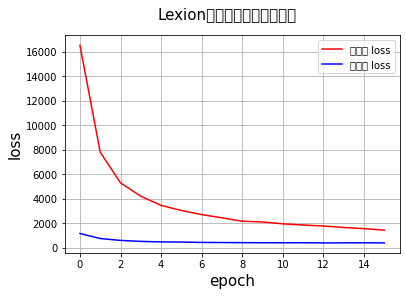

In [76]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()#创建一个figure 
#train_lossss = [11569-i for i in train_log]
train_lossss = train_log
#dev_lossss = [3306-i for i in dev_log]
dev_lossss = dev_log
ax.plot(train_lossss, '-r',label='训练集 loss')
ax.plot(dev_lossss, '-b',label='验证集 loss')

####打开网格
ax.grid(True)

####定义x, y轴的名称
ax.set_xlabel('epoch',fontsize=15)
ax.set_ylabel('loss',fontsize=15)

####定义标题
fig.suptitle('Lexion模型损失函数变化曲线',fontsize=15)

####展示图例 legend loc=是用来定义图例的位置的，还有很多选择，大家可以自己尝试
ax.legend(loc = 'upper right')

In [77]:
gold_test = json.load(open('/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/save_model/LAB1/test_gold-buduan.json','r'))

In [78]:
gold_test[:10]

['B-DRU', 'E-DRU', 'O', 'B-QUA', 'E-QUA', 'O', 'B-DRU', 'E-DRU', 'O', 'B-QUA']

In [79]:
len(gold_test)

3172

In [80]:
pred_test = json.load(open('/content/drive/MyDrive/Colab Notebooks/LexionAN-master-master/save_model/LAB1/test_log-buduan.json','r'))

In [81]:
len(pred_test[-1])

144

In [82]:
p_test = []
for i in pred_test[-1]:
  p_test.extend(i)

In [83]:
len(p_test)

3172

In [84]:
from sklearn.metrics import classification_report
print(classification_report(gold_test, p_test,digits = 4))

              precision    recall  f1-score   support

       B-DRU     0.9175    0.9319    0.9247       191
      B-NAME     0.9459    0.9722    0.9589        36
       B-QUA     0.9341    0.9770    0.9551        87
       B-SYM     0.8614    0.8529    0.8571       102
       B-USE     0.8527    0.8643    0.8584       221
       E-DRU     0.9194    0.9000    0.9096       190
      E-NAME     0.8108    0.8108    0.8108        37
       E-QUA     0.9222    0.9651    0.9432        86
       E-SYM     0.8557    0.8300    0.8426       100
       E-USE     0.8961    0.9241    0.9099       224
       I-DRU     0.6000    0.6522    0.6250        23
      I-NAME     0.9302    0.9091    0.9195        44
       I-QUA     0.9444    0.8500    0.8947        20
       I-SYM     0.8432    0.8478    0.8455       184
       I-USE     0.9040    0.9123    0.9081       650
           O     0.9321    0.9130    0.9224       977

    accuracy                         0.9026      3172
   macro avg     0.8794   